# Analiza Wydajności Ruchu Internetowego

W tym notebooku dokonujemy analizy wydajności ruchu internetowego na podstawie danych UDP, HTTP oraz obciążenia. Na początku obliczamy metryki, a następnie prezentujemy je w formie wykresów, zarówno dla uśrednionych wartości godzinowych, jak i dziennych.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(style='whitegrid')

COLORS = {
    'upload': '#1f77b4',
    'download': '#d62728',
    'latency': '#2ca02c',
    'wifi': '#9467bd',
    'wired': '#ff7f0e',
    'http_get': '#17becf',
    'http_post': '#bcbd22'
}

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'grid.alpha': 0.3
})

## Funkcje Pomocnicze

In [3]:
def add_time_columns(df):
    df['hour'] = df['dtime'].dt.hour
    df['day_of_week'] = df['dtime'].dt.dayofweek.map({
        0: 'Poniedziałek',
        1: 'Wtorek',
        2: 'Środa',
        3: 'Czwartek',
        4: 'Piątek',
        5: 'Sobota',
        6: 'Niedziela'
    })
    return df

## Obliczanie Metryk

W tej części obliczamy metryki dla UDP, HTTP oraz obciążenia, korzystając z danych z odpowiadających plików CSV.

In [4]:
def calculate_metrics():
    # Metryki dla UDP
    udp_df = pd.read_csv('data/curr_udpjitter_clean.csv', parse_dates=['dtime'])
    udp_metrics = {
        "UDP": {
            "Średni Jitter Upload (ms)": udp_df['jitter_up'].mean(),
            "Maksymalny Jitter Download (ms)": udp_df['jitter_down'].max(),
            "Średnia strata pakietów Upload (%)": (udp_df['packets_up_sent'] - udp_df['packets_up_recv']).mean() / udp_df['packets_up_sent'].mean() * 100,
            "Średnie opóźnienie (ms)": udp_df['latency'].mean(),
            "Liczba testów": len(udp_df),
            "Współczynnik zmienności jitter": udp_df['jitter_up'].std() / udp_df['jitter_up'].mean(),
            "95 percentyl opóźnień": udp_df['latency'].quantile(0.95)
        }
    }
    
    # Metryki dla HTTP
    httpget = pd.read_csv("data/curr_httpgetmt_clean.csv", parse_dates=["dtime"])
    httppost = pd.read_csv("data/curr_httppostmt_clean.csv", parse_dates=["dtime"])
    http_metrics = {
        "HTTP GET": {
            "Śr. prędkość (MB/s)": httpget['bytes_sec'].mean() / 1e6,
            "Max prędkość (MB/s)": httpget['bytes_sec'].max() / 1e6,
            "Śr. czas pobierania (s)": httpget['fetch_time'].mean() / 1e6,
            "Procent testów powyżej 10 MB/s": (httpget['bytes_sec'] > 10e6).mean() * 100
        },
        "HTTP POST": {
            "Śr. prędkość (MB/s)": httppost['bytes_sec'].mean() / 1e6,
            "Max prędkość (MB/s)": httppost['bytes_sec'].max() / 1e6,
            "Śr. czas wysyłania (s)": httppost['fetch_time'].mean() / 1e6,
            "Procent testów powyżej 10 MB/s": (httpget['bytes_sec'] > 10e6).mean() * 100
        }
    }
    
    # Metryki dla Obciążenia
    load_df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
    load_metrics = {
        "Obciążenie": {
            "Śr. pobieranie Wi-Fi (MB)": load_df['cust_wifi_rx_bytes'].mean() / 1e6,
            "Całkowite pobieranie przewodowe (MB)": load_df['cust_wired_rx_bytes'].sum() / 1e6,
            "Max wysyłanie Wi-Fi (MB)": load_df['cust_wifi_tx_bytes'].max() / 1e6,
            "Stosunek Wi-Fi/Przewodowe": (load_df['cust_wifi_rx_bytes'].sum() / load_df['cust_wired_rx_bytes'].sum()).round(2)
        }
    }
    
    return {"UDP": udp_metrics, "HTTP": http_metrics, "Obciążenie": load_metrics}

def print_metrics(metrics):
    for category in metrics:
        print(f"\n{'='*40}\nMetryki {category}\n{'='*40}")
        df = pd.DataFrame(metrics[category]).T
        display(df.style.format("{:.2f}"))

metrics = calculate_metrics()
print_metrics(metrics)


Metryki UDP


,Średni Jitter Upload (ms),Maksymalny Jitter Download (ms),Średnia strata pakietów Upload (%),Średnie opóźnienie (ms),Liczba testów,Współczynnik zmienności jitter,95 percentyl opóźnień
UDP,3362.36,2841873.00,0.09,25762.76,2662386.00,6.47,51942.00



Metryki HTTP


,Śr. prędkość (MB/s),Max prędkość (MB/s),Śr. czas pobierania (s),Procent testów powyżej 10 MB/s,Śr. czas wysyłania (s)
HTTP GET,33.45,118.61,10.04,65.29,nan
HTTP POST,14.25,119.00,nan,65.29,10.00



Metryki Obciążenie


,Śr. pobieranie Wi-Fi (MB),Całkowite pobieranie przewodowe (MB),Max wysyłanie Wi-Fi (MB),Stosunek Wi-Fi/Przewodowe
Obciążenie,243.83,331697197.41,35358.50,2.04


## Wizualizacja Danych - UDP

Poniżej prezentujemy wykresy zgromadzonych parametrów dla danych UDP, zarówno na poziomie godzinowym jak i dziennym.

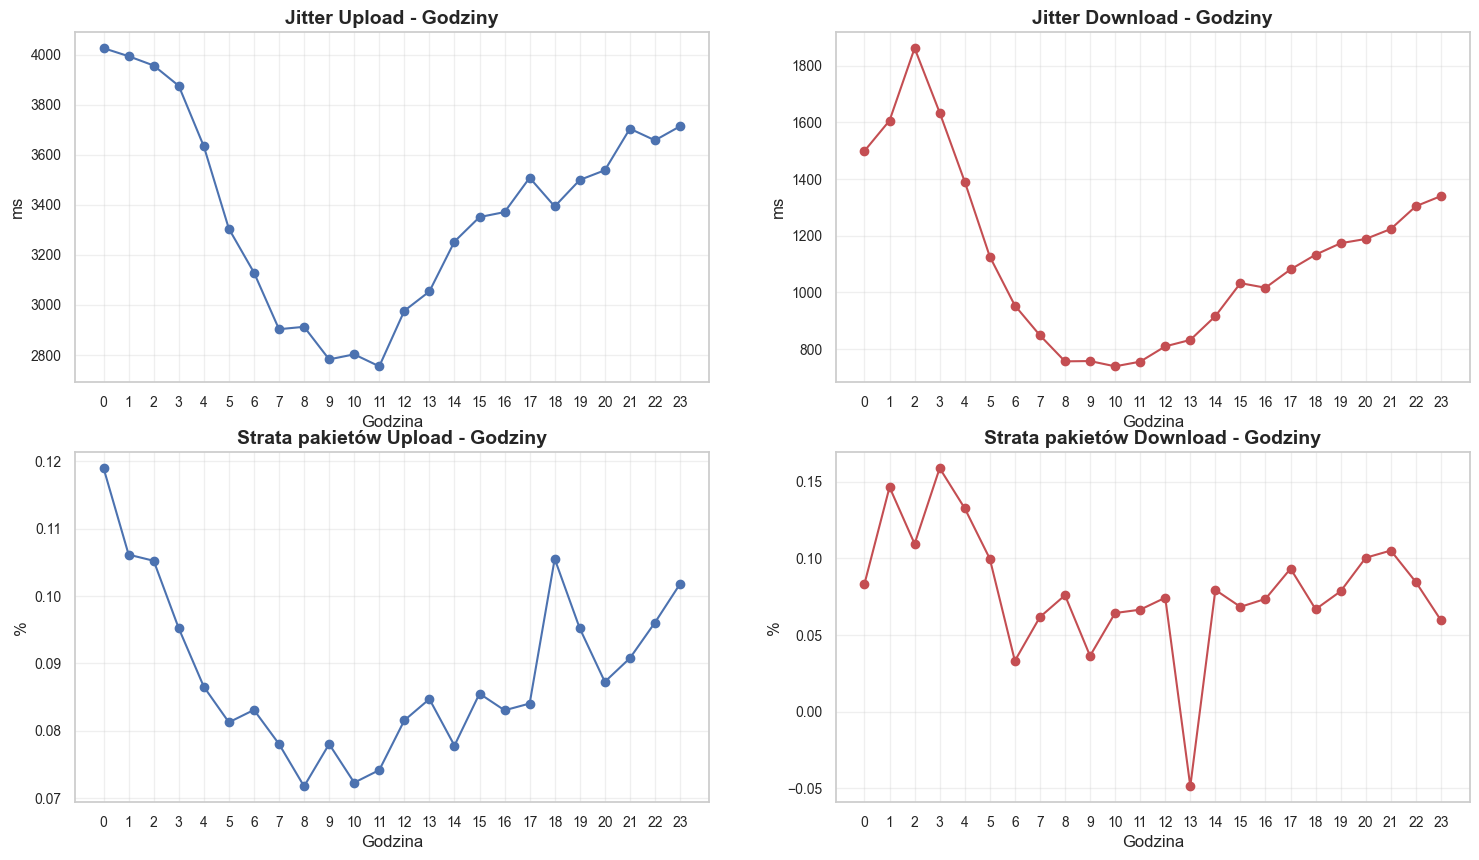

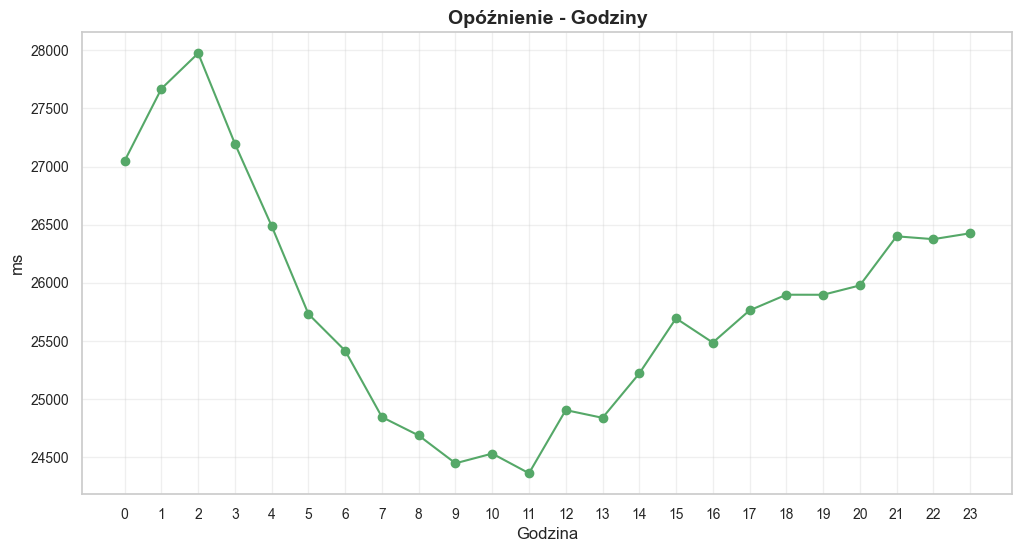

In [5]:
# Wczytanie danych UDP
udp_df = pd.read_csv('data/curr_udpjitter_clean.csv', parse_dates=['dtime'])
udp_df = add_time_columns(udp_df)

# Obliczenie strat pakietów
udp_df['packet_loss_up'] = (udp_df['packets_up_sent'] - udp_df['packets_up_recv']) / udp_df['packets_up_sent'] * 100
udp_df['packet_loss_down'] = (udp_df['packets_down_sent'] - udp_df['packets_down_recv']) / udp_df['packets_down_sent'] * 100

# Grupowanie wg godziny i dni tygodnia
udp_hourly = udp_df.groupby('hour').mean(numeric_only=True).reset_index()
udp_daily = udp_df.groupby('day_of_week').mean(numeric_only=True).reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

plt.figure(figsize=(18, 10))

# Wykresy godzinowe
plt.subplot(2,2,1)
plt.plot(udp_hourly['hour'], udp_hourly['jitter_up'], 'b-o')
plt.title('Jitter Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(udp_hourly['hour'], udp_hourly['jitter_down'], 'r-o')
plt.title('Jitter Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_up'], 'b-o')
plt.title('Strata pakietów Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_down'], 'r-o')
plt.title('Strata pakietów Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['latency'], 'g-o')
plt.title('Opóźnienie - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Wizualizacja Danych - HTTP

Poniższe wykresy pokazują wyniki dla HTTP GET (download) i HTTP POST (upload).

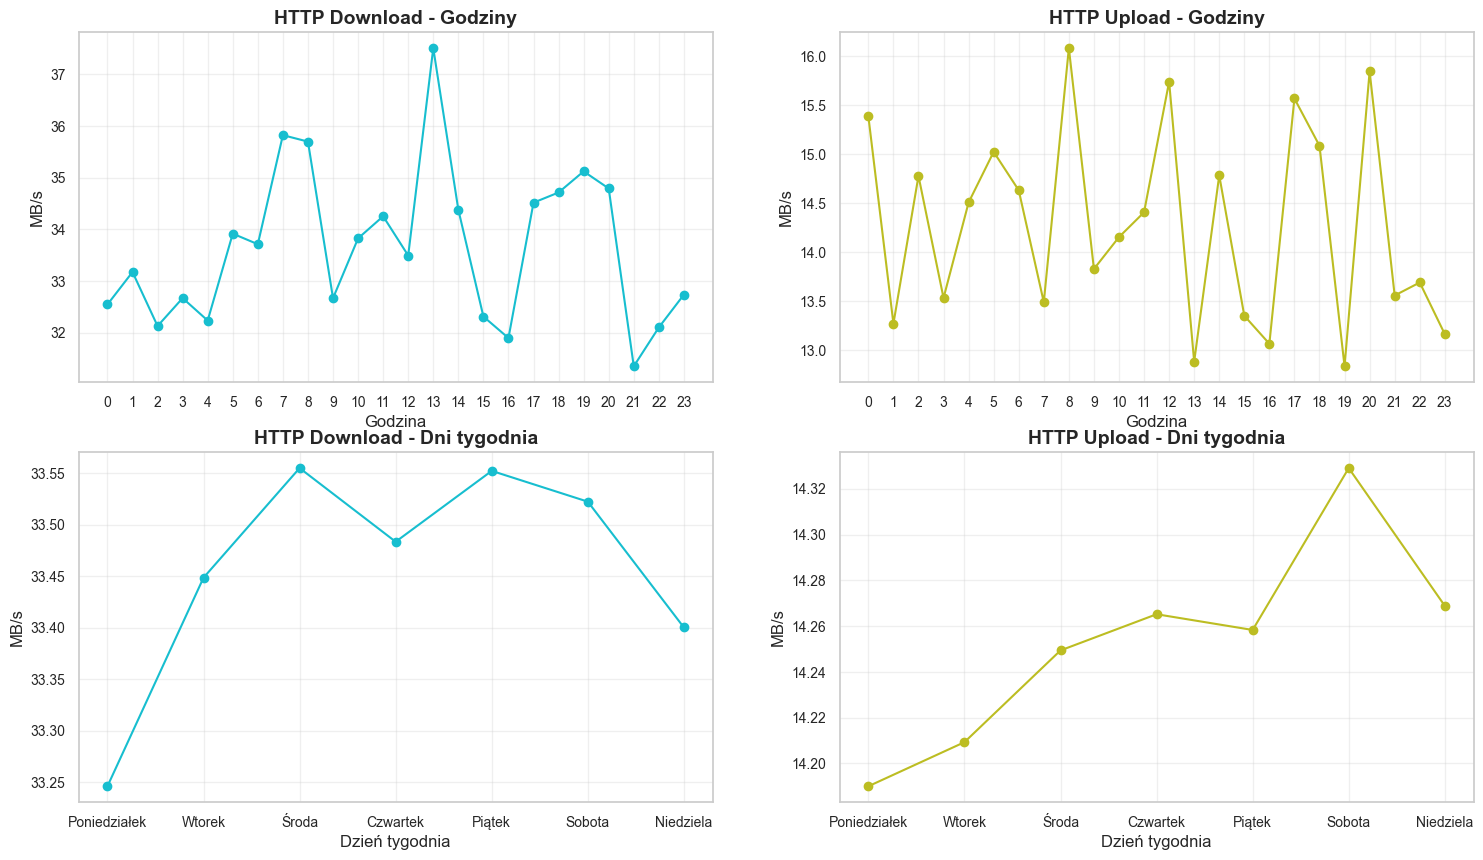

In [6]:
# Wczytanie danych HTTP
httpget = pd.read_csv("data/curr_httpgetmt_clean.csv", parse_dates=["dtime"])
httppost = pd.read_csv("data/curr_httppostmt_clean.csv", parse_dates=["dtime"])

httpget = add_time_columns(httpget)
httppost = add_time_columns(httppost)

httpget['MB/s'] = httpget['bytes_sec'] / 1e6
httppost['MB/s'] = httppost['bytes_sec'] / 1e6

# Grupowanie wg godziny
httpget_hourly = httpget.groupby('hour')['MB/s'].mean().reset_index()
httppost_hourly = httppost.groupby('hour')['MB/s'].mean().reset_index()

plt.figure(figsize=(18, 10))
# Wykresy godzinowe dla HTTP
plt.subplot(2, 2, 1)
plt.plot(httpget_hourly['hour'], httpget_hourly['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(httppost_hourly['hour'], httppost_hourly['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)

# Grupowanie wg dni
httpget_daily = httpget.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
httppost_daily = httppost.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

# Wykresy dzienne dla HTTP
plt.subplot(2, 2, 3)
plt.plot(httpget_daily['day_of_week'], httpget_daily['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(httppost_daily['day_of_week'], httppost_daily['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)
plt.show()

## Wizualizacja Danych - Obciążenie

Poniższe wykresy prezentują intensywność ruchu dla połączeń Wi-Fi i przewodowych.

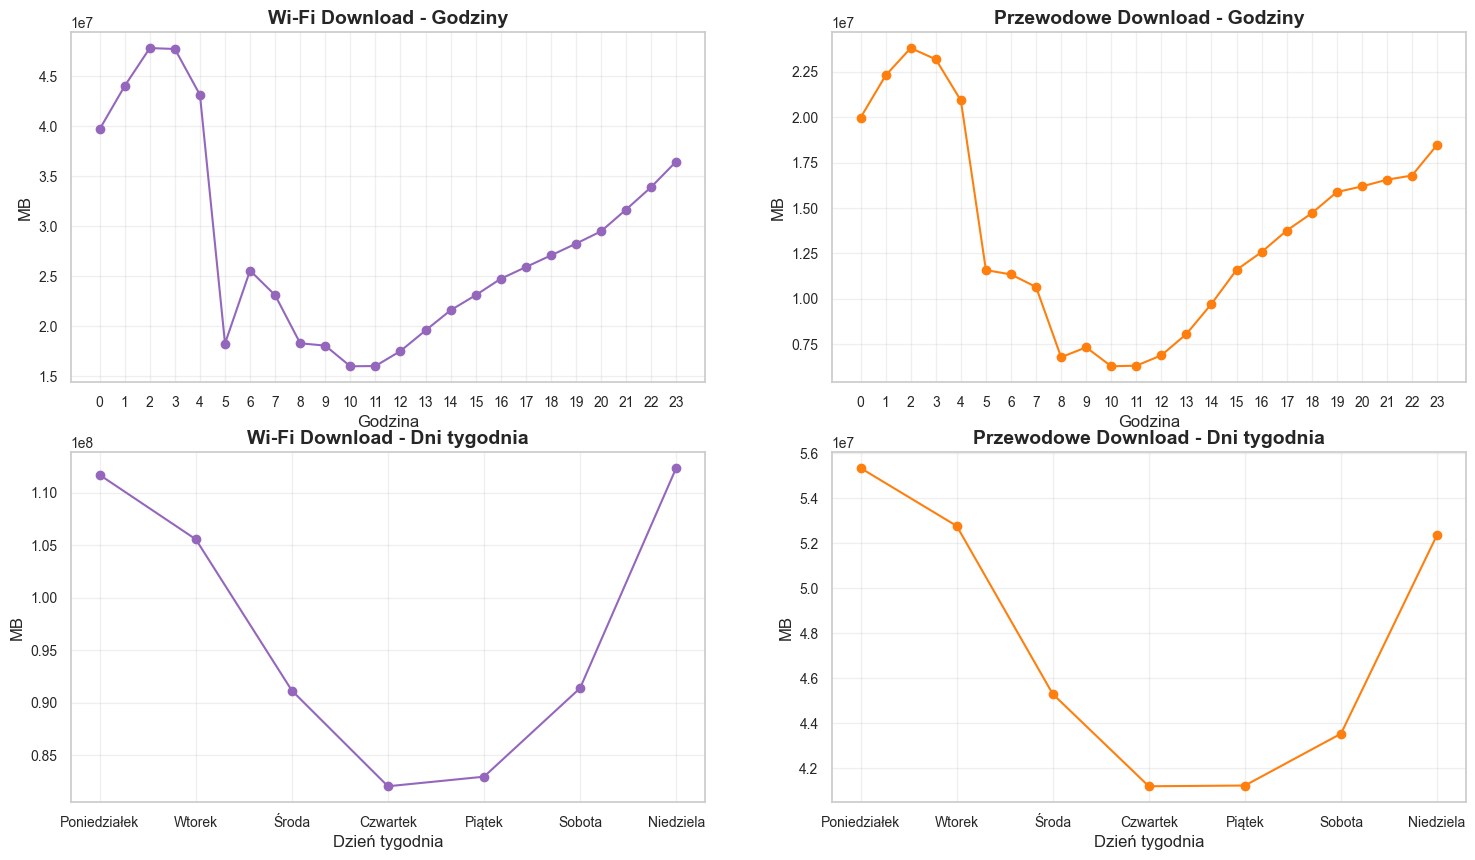

In [7]:
# Wczytanie danych obciążenia
load_df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
load_df = add_time_columns(load_df)

for col in ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']:
    load_df[col] = load_df[col] / 1e6

# Grupowanie wg godzin
hourly_wifi_rx = load_df.groupby('hour')['cust_wifi_rx_bytes'].sum().reset_index()
hourly_wired_rx = load_df.groupby('hour')['cust_wired_rx_bytes'].sum().reset_index()

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(hourly_wifi_rx['hour'], hourly_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(hourly_wired_rx['hour'], hourly_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)

# Grupowanie wg dni
daily_wifi_rx = load_df.groupby('day_of_week')['cust_wifi_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
daily_wired_rx = load_df.groupby('day_of_week')['cust_wired_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

plt.subplot(2, 2, 3)
plt.plot(daily_wifi_rx['day_of_week'], daily_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(daily_wired_rx['day_of_week'], daily_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)
plt.show()

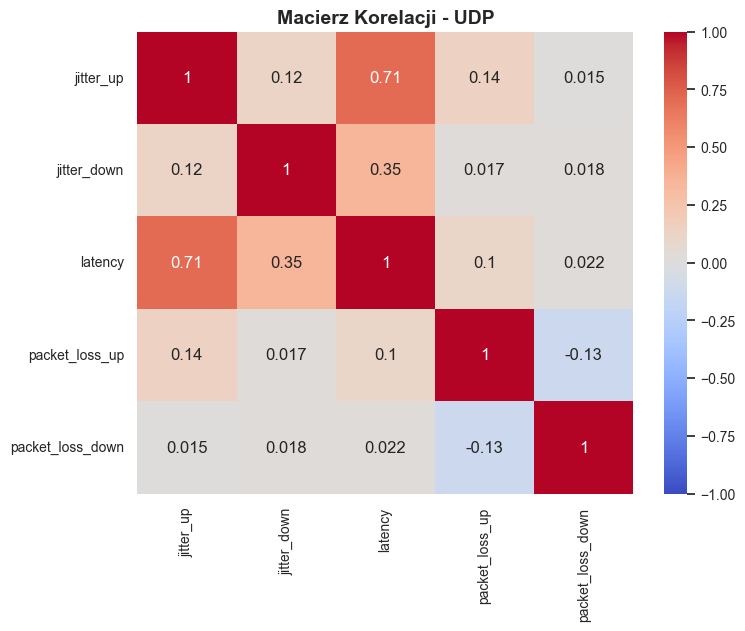

In [8]:
# Komórka: Analiza korelacji UDP
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór kolumn do analizy korelacji dla UDP
corr_columns_udp = ['jitter_up', 'jitter_down', 'latency', 'packet_loss_up', 'packet_loss_down']

# Obliczenie macierzy korelacji
corr_matrix_udp = udp_df[corr_columns_udp].corr()

# Wizualizacja przy użyciu heatmapy
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_udp, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz Korelacji - UDP')
plt.show()

Macierz Korelacji - UDP
Jitter Upload (jitter_up) ma silną dodatnią korelację z opóźnieniem (latency) na poziomie 0.71, co sugeruje, że większy jitter w transmisji upload wpływa na wzrost opóźnienia.
Korelacja między jitter_down a latency wynosi 0.35, co wskazuje na umiarkowaną zależność.
Straty pakietów (packet_loss_up i packet_loss_down) mają bardzo słabe korelacje z pozostałymi parametrami (wartości bliskie 0), co oznacza, że nie są one bezpośrednio związane z jitterem ani opóźnieniem.

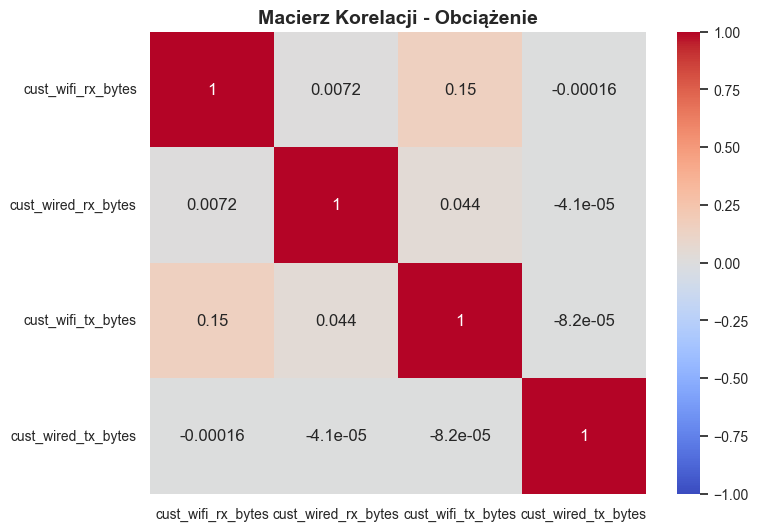

In [9]:
# Komórka: Analiza korelacji Obciążenie
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych obciążenia oraz przygotowanie kolumn
load_df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
load_df = add_time_columns(load_df)
for col in ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']:
    load_df[col] = load_df[col] / 1e6

# Wybór kolumn do analizy korelacji dla obciążenia
corr_columns_load = ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']

# Obliczenie macierzy korelacji
corr_matrix_load = load_df[corr_columns_load].corr()

# Wizualizacja korelacji
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_load, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz Korelacji - Obciążenie')
plt.show()

Macierz Korelacji - Obciążenie
Korelacja między Wi-Fi Download (cust_wifi_rx_bytes) a Wi-Fi Upload (cust_wifi_tx_bytes) wynosi 0.15, co wskazuje na słabą zależność. Oznacza to, że intensywność pobierania i wysyłania w sieci Wi-Fi nie są silnie powiązane.
Korelacja między przewodowym pobieraniem (cust_wired_rx_bytes) a przewodowym wysyłaniem (cust_wired_tx_bytes) wynosi -0.00016, co wskazuje na brak związku między tymi parametrami.
Korelacje między Wi-Fi a przewodowymi transmisjami (zarówno download, jak i upload) są bardzo niskie (bliskie 0), co sugeruje, że te dwa typy transmisji działają niezależnie od siebie.

### Analiza wyników wykresów:

#### **1. Obciążenie (Wi-Fi i przewodowe)**
- **Wi-Fi Download - Godziny**: Pobieranie danych przez Wi-Fi jest najwyższe w godzinach nocnych (szczyt około godziny 2:00), a następnie spada do minimum w godzinach porannych (około 8:00). W ciągu dnia stopniowo rośnie, osiągając kolejny szczyt wieczorem (około 22:00). Może to wynikać z intensywnego korzystania z internetu w godzinach nocnych i wieczornych przez użytkowników domowych.
- **Przewodowe Download - Godziny**: Pobieranie danych przez połączenie przewodowe wykazuje podobny trend, ale wartości są niższe niż dla Wi-Fi. Szczyt przypada na godziny nocne (około 2:00), a minimum na godziny poranne (około 8:00). Wskazuje to na mniejsze wykorzystanie przewodowego internetu w porównaniu do Wi-Fi.
- **Wi-Fi Download - Dni tygodnia**: Pobieranie danych przez Wi-Fi jest najwyższe w weekendy (szczególnie w niedzielę), co może wynikać z większej aktywności użytkowników w domu. W dni robocze (środa, czwartek) wartości są niższe.
- **Przewodowe Download - Dni tygodnia**: Pobieranie danych przez połączenie przewodowe jest najwyższe w poniedziałek, a najniższe w środku tygodnia (środa, czwartek). W weekendy wartości rosną, co może wskazywać na większe wykorzystanie internetu w celach rozrywkowych.

---

#### **2. HTTP (Download i Upload)**
- **HTTP Download - Godziny**: Prędkość pobierania danych (HTTP GET) jest stosunkowo stabilna w ciągu dnia, z niewielkimi wahaniami. Szczyt prędkości występuje około godziny 12:00, co może być związane z mniejszym obciążeniem sieci w tym czasie.
- **HTTP Upload - Godziny**: Prędkość wysyłania danych (HTTP POST) wykazuje większe wahania w ciągu dnia. Szczyty występują w godzinach nocnych i wieczornych, co może być związane z intensywnym przesyłaniem danych przez użytkowników (np. przesyłanie plików, backupy).
- **HTTP Download - Dni tygodnia**: Prędkość pobierania danych jest najwyższa w czwartek i piątek, a najniższa w niedzielę. Może to wynikać z większego obciążenia sieci w weekendy.
- **HTTP Upload - Dni tygodnia**: Prędkość wysyłania danych jest najwyższa w sobotę, co może być związane z intensywnym przesyłaniem danych przez użytkowników w czasie wolnym.

---

#### **3. Opóźnienie (Latency)**
- **Opóźnienie - Godziny**: Opóźnienie (latency) jest najwyższe w godzinach nocnych (szczyt około godziny 2:00), a następnie spada do minimum w godzinach porannych (około 8:00). W ciągu dnia stopniowo rośnie, osiągając kolejny szczyt wieczorem. Wysokie opóźnienia w nocy mogą być związane z większym obciążeniem sieci przez użytkowników domowych.

---

#### **4. UDP (Jitter i Straty Pakietów)**
- **Jitter Upload - Godziny**: Zmienność opóźnienia (jitter) w upload jest najwyższa w godzinach nocnych (około 2:00) i spada do minimum w godzinach porannych (około 8:00). W ciągu dnia jitter rośnie, osiągając kolejny szczyt wieczorem. Wskazuje to na większą niestabilność połączenia w godzinach szczytu.
- **Jitter Download - Godziny**: Zmienność opóźnienia w download wykazuje podobny trend, ale wartości są niższe niż dla upload. Szczyt występuje w godzinach nocnych, a minimum w godzinach porannych.
- **Strata Pakietów Upload - Godziny**: Straty pakietów w upload są stosunkowo niskie, ale wykazują niewielkie wahania w ciągu dnia. Szczyt strat występuje w godzinach nocnych.
- **Strata Pakietów Download - Godziny**: Straty pakietów w download są również niskie, ale bardziej zmienne niż w upload. Szczyty występują w godzinach nocnych i wieczornych.



# Analiza danych z 2021 roku

In [10]:
def calculate_metrics():
    # Metryki dla UDP
    udp_df = pd.read_csv('data/202101/curr_udpjitter_clean.csv', parse_dates=['dtime'])
    udp_metrics = {
        "UDP": {
            "Średni Jitter Upload (ms)": udp_df['jitter_up'].mean(),
            "Maksymalny Jitter Download (ms)": udp_df['jitter_down'].max(),
            "Średnia strata pakietów Upload (%)": (udp_df['packets_up_sent'] - udp_df['packets_up_recv']).mean() / udp_df['packets_up_sent'].mean() * 100,
            "Średnie opóźnienie (ms)": udp_df['latency'].mean(),
            "Liczba testów": len(udp_df),
            "Współczynnik zmienności jitter": udp_df['jitter_up'].std() / udp_df['jitter_up'].mean(),
            "95 percentyl opóźnień": udp_df['latency'].quantile(0.95)
        }
    }
    
    # Metryki dla HTTP
    httpget = pd.read_csv("data/202101/curr_httpgetmt_clean.csv", parse_dates=["dtime"])
    httppost = pd.read_csv("data/202101/curr_httppostmt_clean.csv", parse_dates=["dtime"])
    http_metrics = {
        "HTTP GET": {
            "Śr. prędkość (MB/s)": httpget['bytes_sec'].mean() / 1e6,
            "Max prędkość (MB/s)": httpget['bytes_sec'].max() / 1e6,
            "Śr. czas pobierania (s)": httpget['fetch_time'].mean() / 1e6,
            "Procent testów powyżej 10 MB/s": (httpget['bytes_sec'] > 10e6).mean() * 100
        },
        "HTTP POST": {
            "Śr. prędkość (MB/s)": httppost['bytes_sec'].mean() / 1e6,
            "Max prędkość (MB/s)": httppost['bytes_sec'].max() / 1e6,
            "Śr. czas wysyłania (s)": httppost['fetch_time'].mean() / 1e6,
            "Procent testów powyżej 10 MB/s": (httpget['bytes_sec'] > 10e6).mean() * 100
        }
    }
    
    # Metryki dla Obciążenia
    load_df = pd.read_csv("data/202101/curr_datausage.csv", parse_dates=["dtime"])
    load_metrics = {
        "Obciążenie": {
            "Śr. pobieranie Wi-Fi (MB)": load_df['cust_wifi_rx_bytes'].mean() / 1e6,
            "Całkowite pobieranie przewodowe (MB)": load_df['cust_wired_rx_bytes'].sum() / 1e6,
            "Max wysyłanie Wi-Fi (MB)": load_df['cust_wifi_tx_bytes'].max() / 1e6,
            "Stosunek Wi-Fi/Przewodowe": (load_df['cust_wifi_rx_bytes'].sum() / load_df['cust_wired_rx_bytes'].sum()).round(2)
        }
    }
    
    return {"UDP": udp_metrics, "HTTP": http_metrics, "Obciążenie": load_metrics}

def print_metrics(metrics):
    for category in metrics:
        print(f"\n{'='*40}\nMetryki {category}\n{'='*40}")
        df = pd.DataFrame(metrics[category]).T
        display(df.style.format("{:.2f}"))

metrics = calculate_metrics()
print_metrics(metrics)


Metryki UDP


,Średni Jitter Upload (ms),Maksymalny Jitter Download (ms),Średnia strata pakietów Upload (%),Średnie opóźnienie (ms),Liczba testów,Współczynnik zmienności jitter,95 percentyl opóźnień
UDP,4224.39,30131286.00,1.66,29227.39,6322673.00,47.68,56648.00



Metryki HTTP


,Śr. prędkość (MB/s),Max prędkość (MB/s),Śr. czas pobierania (s),Procent testów powyżej 10 MB/s,Śr. czas wysyłania (s)
HTTP GET,18.67,118.19,10.03,49.79,nan
HTTP POST,8.33,120.21,nan,49.79,10.00



Metryki Obciążenie


,Śr. pobieranie Wi-Fi (MB),Całkowite pobieranie przewodowe (MB),Max wysyłanie Wi-Fi (MB),Stosunek Wi-Fi/Przewodowe
Obciążenie,240.85,-9222887374892.33,63211.79,-0.00


## Wizualizacja Danych - UDP

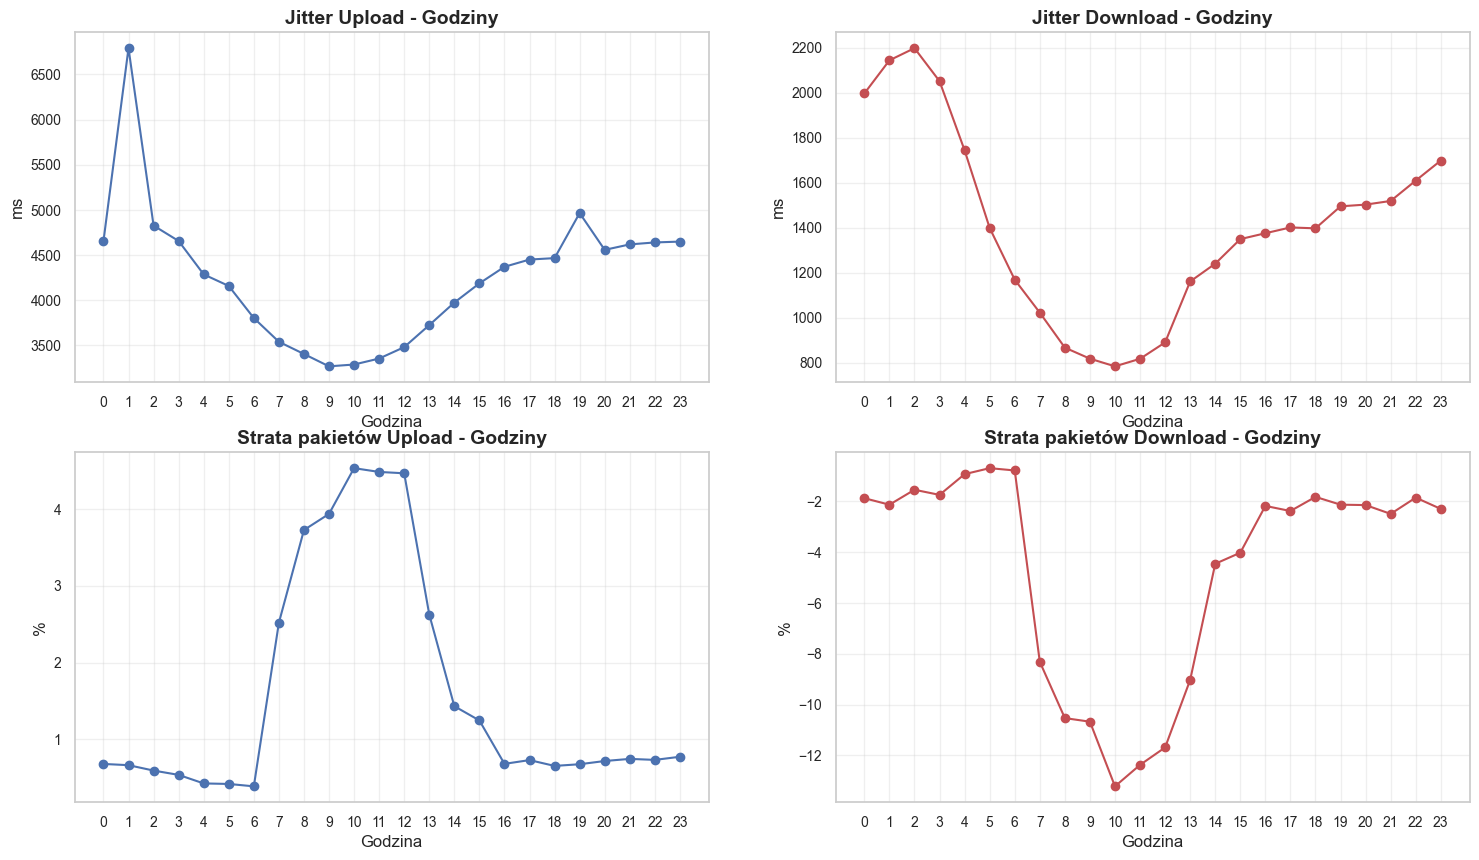

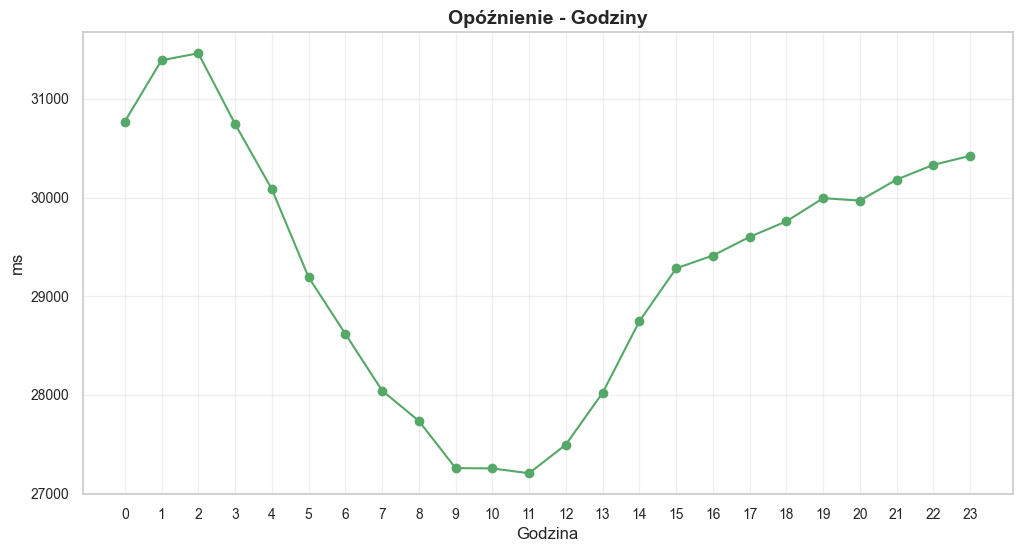

In [11]:
# Wczytanie danych UDP
udp_df = pd.read_csv('data/202101/curr_udpjitter_clean.csv', parse_dates=['dtime'])
udp_df = add_time_columns(udp_df)

# Obliczenie strat pakietów
udp_df['packet_loss_up'] = (udp_df['packets_up_sent'] - udp_df['packets_up_recv']) / udp_df['packets_up_sent'] * 100
udp_df['packet_loss_down'] = (udp_df['packets_down_sent'] - udp_df['packets_down_recv']) / udp_df['packets_down_sent'] * 100

# Grupowanie wg godziny i dni tygodnia
udp_hourly = udp_df.groupby('hour').mean(numeric_only=True).reset_index()
udp_daily = udp_df.groupby('day_of_week').mean(numeric_only=True).reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

plt.figure(figsize=(18, 10))

# Wykresy godzinowe
plt.subplot(2,2,1)
plt.plot(udp_hourly['hour'], udp_hourly['jitter_up'], 'b-o')
plt.title('Jitter Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(udp_hourly['hour'], udp_hourly['jitter_down'], 'r-o')
plt.title('Jitter Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_up'], 'b-o')
plt.title('Strata pakietów Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(udp_hourly['hour'], udp_hourly['packet_loss_down'], 'r-o')
plt.title('Strata pakietów Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('%')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

plt.figure()
plt.plot(udp_hourly['hour'], udp_hourly['latency'], 'g-o')
plt.title('Opóźnienie - Godziny')
plt.xlabel('Godzina')
plt.ylabel('ms')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Wizualizacja Danych - HTTP

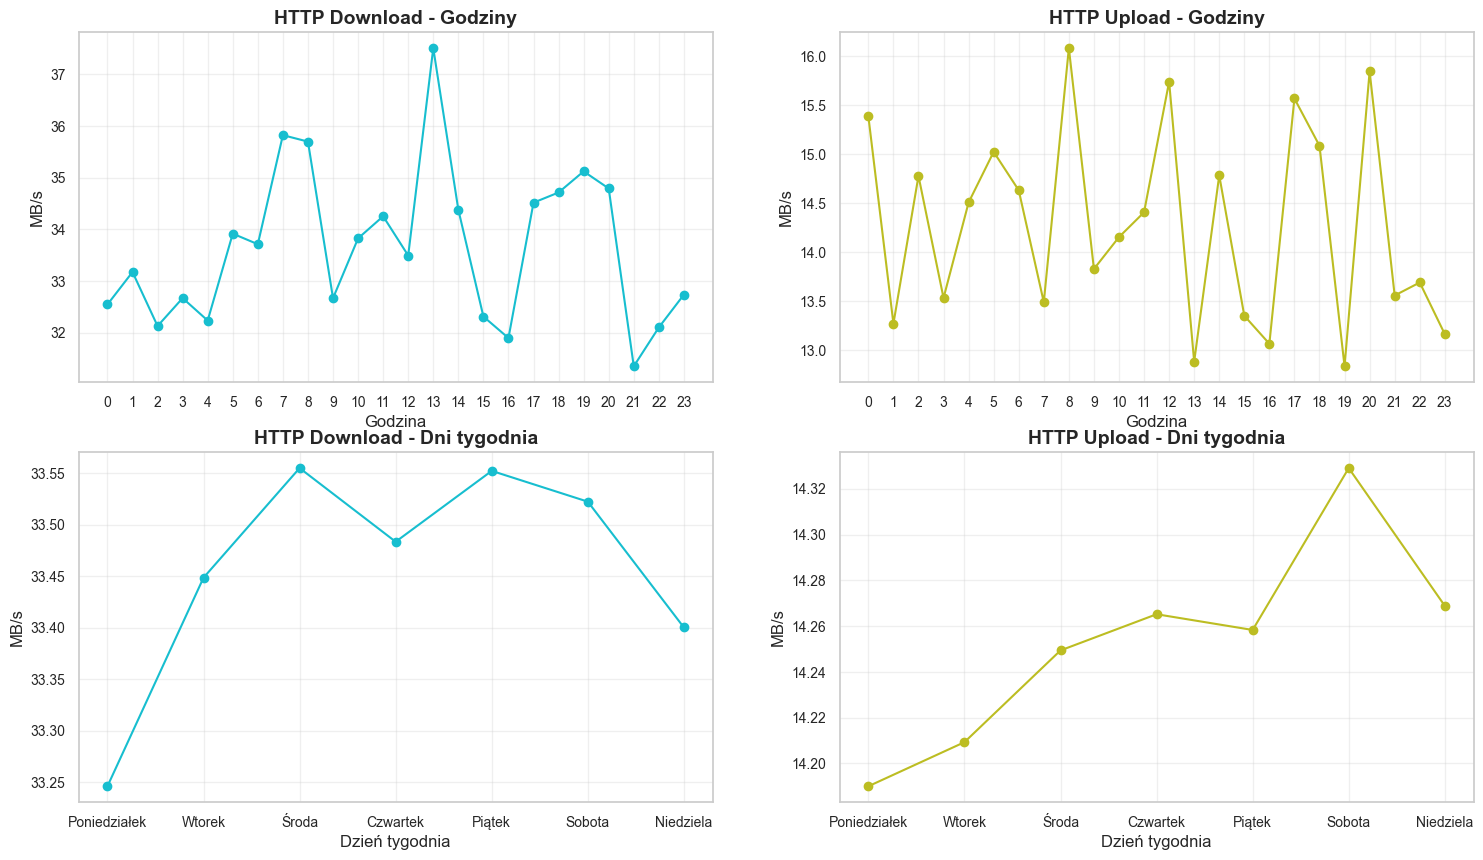

In [12]:
# Wczytanie danych HTTP
httpget = pd.read_csv("data/curr_httpgetmt_clean.csv", parse_dates=["dtime"])
httppost = pd.read_csv("data/curr_httppostmt_clean.csv", parse_dates=["dtime"])

httpget = add_time_columns(httpget)
httppost = add_time_columns(httppost)

httpget['MB/s'] = httpget['bytes_sec'] / 1e6
httppost['MB/s'] = httppost['bytes_sec'] / 1e6

# Grupowanie wg godziny
httpget_hourly = httpget.groupby('hour')['MB/s'].mean().reset_index()
httppost_hourly = httppost.groupby('hour')['MB/s'].mean().reset_index()

plt.figure(figsize=(18, 10))
# Wykresy godzinowe dla HTTP
plt.subplot(2, 2, 1)
plt.plot(httpget_hourly['hour'], httpget_hourly['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(httppost_hourly['hour'], httppost_hourly['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB/s')
plt.xticks(range(0, 24))
plt.grid(True)

# Grupowanie wg dni
httpget_daily = httpget.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
httppost_daily = httppost.groupby('day_of_week')['MB/s'].mean().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

# Wykresy dzienne dla HTTP
plt.subplot(2, 2, 3)
plt.plot(httpget_daily['day_of_week'], httpget_daily['MB/s'], 'o-', color=COLORS['http_get'])
plt.title('HTTP Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(httppost_daily['day_of_week'], httppost_daily['MB/s'], 'o-', color=COLORS['http_post'])
plt.title('HTTP Upload - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB/s')
plt.grid(True)
plt.show()

## Wizualizacja Danych - Obciążenie

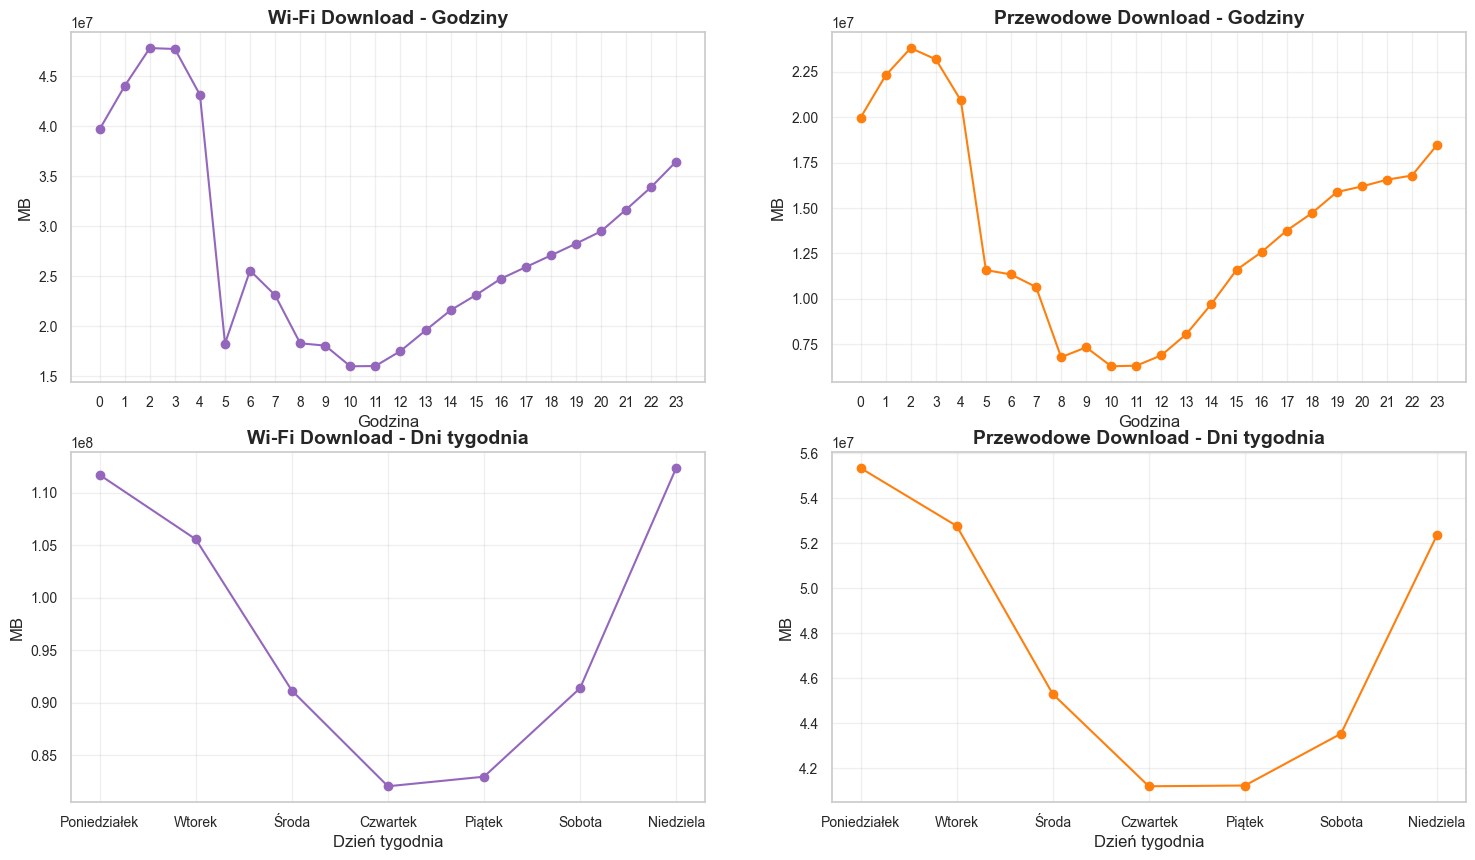

In [13]:
# Wczytanie danych obciążenia
load_df = pd.read_csv("data/curr_datausage.csv", parse_dates=["dtime"])
load_df = add_time_columns(load_df)

for col in ['cust_wifi_rx_bytes', 'cust_wired_rx_bytes', 'cust_wifi_tx_bytes', 'cust_wired_tx_bytes']:
    load_df[col] = load_df[col] / 1e6

# Grupowanie wg godzin
hourly_wifi_rx = load_df.groupby('hour')['cust_wifi_rx_bytes'].sum().reset_index()
hourly_wired_rx = load_df.groupby('hour')['cust_wired_rx_bytes'].sum().reset_index()

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(hourly_wifi_rx['hour'], hourly_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(hourly_wired_rx['hour'], hourly_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Godziny')
plt.xlabel('Godzina')
plt.ylabel('MB')
plt.xticks(range(0, 24))
plt.grid(True)

# Grupowanie wg dni
daily_wifi_rx = load_df.groupby('day_of_week')['cust_wifi_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()
daily_wired_rx = load_df.groupby('day_of_week')['cust_wired_rx_bytes'].sum().reindex([
    'Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'
]).reset_index()

plt.subplot(2, 2, 3)
plt.plot(daily_wifi_rx['day_of_week'], daily_wifi_rx['cust_wifi_rx_bytes'], 'o-', color=COLORS['wifi'])
plt.title('Wi-Fi Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(daily_wired_rx['day_of_week'], daily_wired_rx['cust_wired_rx_bytes'], 'o-', color=COLORS['wired'])
plt.title('Przewodowe Download - Dni tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('MB')
plt.grid(True)
plt.show()

## Wnioski:

Wyniki z roku 2023 i 2021 mają identyczne trendy. Największa różnica jest w utraconych pakietach, w przypadku danych z 2021 roku jest ich o wiele więcej.